<a href="https://colab.research.google.com/github/IanWangg/OSRPG/blob/master/mpsf_final_final_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import copy

import gym

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title FourRooms
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.
Modified to return one hot encoded states and gym compatible.
"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRooms(gym.Env):

    def __init__(self, goal=62, p=0, config=1, layout='3roomsh', random_goal=False):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        if(layout == '4rooms'):
            layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        elif(layout == '3rooms'):
            layout = """\
wwwwwwwwwwwww
w   w   w   w
w   w       w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w       w   w
w   w   w   w
w   w   w   w
wwwwwwwwwwwww
"""
        elif(layout == '3roomsh'):
            layout = """\
wwwwwwwwwwwww
w           w
w           w
wwwwwwwww www
w           w
w           w
w           w
w           w
ww wwwwwwwwww
w           w
w           w
w           w
wwwwwwwwwwwww
"""
        elif(layout == 'maze'):
            layout = """\
wwwwwwwwwwwww
w           w
w ww wwwwww w
w w       w w
w w wwwww w w
w w w   w w w
w w   w   www
w w w   w w w
w w wwwww w w
w w       w w
w ww wwwwww w
w           w
wwwwwwwwwwwww
"""
        elif(layout == 'open'):
            layout = """\
wwwwwwwwwwwww
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
wwwwwwwwwwwww
"""
        else:
            raise
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))

        # Setting the observation space based on the config
        if(config <= 1):
            self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        elif(config == 2):
            self.observation_space = spaces.Box(low=np.zeros(169), high=np.ones(169), dtype=np.uint8)

        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}

        self.random_goal = random_goal
        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        if self.random_goal:
            self.goal = self.rng.choice(self.init_states)
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True, show_agent=True):
        current_grid = np.array(self.occupancy)
        if(show_agent):
            current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def render_state(self):
        occupancy = self.occupancy * 0.01
        current_grid = np.array(occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = 1
        goal_cell = self.tocell[self.goal]
        current_grid[goal_cell[0], goal_cell[1]] = -0.01
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, init=None):
        self.updates = 0
        if(init is None):
            state = self.rng.choice(self.init_states)
        else:
            state = init
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp
        elif(self.config == 2):
            return self.render_state().flatten()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return self.render_state().flatten(), reward, done, {}

class FourRoomsMatrix(FourRooms):
    def __init__(self, goal=62, p=0, layout='3roomsh'):
        FourRooms.__init__(self, goal=goal, p=p, config=2, layout=layout)


class FourRoomsNoTerm(FourRooms):
    """
    Environment with no terminal state but with a probability of dying.
    """
    def __init__(self, p=0, dying=0, config=1, layout='3roomsh'):
        FourRooms.__init__(self, p=p, config=config, layout='3roomsh')
        self.dying = dying

    def render(self):
        return FourRooms.render(self, show_goal=False)

    def render_state(self):
        occupancy = self.occupancy * 0.01
        current_grid = np.array(occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = 1
        goal_cell = self.tocell[self.goal]
        return current_grid

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1
        reward = 0 # reward is always 0

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]
            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        if(self.rng.uniform() < self.dying): # randomly check if the agent dies
            done = 1
        else:
            done = 0

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return self.render_state().flatten(), reward, done, {}


class FourRoomsMatrixNoTerm(FourRoomsNoTerm):
    def __init__(self, p=0, dying=0.01, layout='3roomsh'):
        FourRoomsNoTerm.__init__(self, p=p, dying=dying, config=2, layout='3roomsh')

In [ ]:
#@title ReplayBuffer
class ReplayBuffer(object):
	def __init__(self, max_size=int(1e5)):
		self.max_size = max_size
		self.device = device

		self.ptr = 0
		self.size = 0

		self.state = np.zeros((self.max_size, 169))
		self.action = np.zeros((self.max_size, 1))
		self.next_state = np.array(self.state)
		self.reward = np.zeros((self.max_size, 1))
		self.not_done = np.zeros((self.max_size, 1))

	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)
		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.LongTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [ ]:
#@title Training Methods
from tqdm import tqdm
def eval_policy(policy, env, eval_episodes=20):
    eval_env = env

    avg_reward = 0
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state), eval=True)
            state, reward, done, info = eval_env.step(action)
            done_float = float(done)
            avg_reward += 1

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

def collect_replay_buffer(
    num_agents=30,
    env_func=FourRooms,
    batch_size=16,
    transitions_per_expert=int(1e4),
):

    expert_replay_buffer = ReplayBuffer(max_size=transitions_per_expert * num_agents)
    print('================ Training Agents =================')
    for i in tqdm(range(num_agents)):
        env = env_func(config=2, random_goal=True)
        policy, _ = train_agent(DQN(), env, max_steps=int(1e4), exploration_steps=int(1e3), eval_frequency=int(1e4))

        done = False
        state = env.reset()
        for step in range(transitions_per_expert):
            action = policy.select_action(np.array(state), eval=True)
            next_state, reward, done, info = env.step(action)
            done_bool = float(done)

            expert_replay_buffer.add(state, action, next_state, reward, done_bool)

            state = copy.copy(next_state)

            if done:
                state = env.reset()
                done = False
    
    return expert_replay_buffer

def collect_random_replay_buffer(
    env_func=FourRooms,
    max_size=int(3e5)
):
    random_replay_buffer = ReplayBuffer(max_size=max_size)

    try:
        env = env_func(config = 2)
    except:
        env = env_func()

    done = False
    state = env.reset()
    for i in tqdm(range(max_size)):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        done_bool = float(done)

        expert_replay_buffer.add(state, action, next_state, reward, done_bool)

        state = copy.copy(next_state)

        if done:
            state = env.reset()
            done = False

    return random_replay_buffer
            
            

def train_agent(
    agent,
    env,
    max_steps=int(1e5),
    exploration_steps=int(1e4),
    eval_frequency=int(1e3),
    replay_buffer=None,
    batch_size=16,
):
    eval_env = env

    if replay_buffer is None:
        replay_buffer = ReplayBuffer(max_size=max_steps)

    evaluations = []

    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    policy = agent
    
    # start training the agent
    for t in range(int(max_steps)):
        episode_timesteps += 1
        
        if t < exploration_steps:
            action = env.action_space.sample()
        else:
            action = policy.select_action(np.array(state), eval=True)

        # Perform action and log results
        next_state, reward, done, info = env.step(action)
        episode_reward += reward

        # determine if the agent reaches the goal
        done_float = float(done)
            
        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_float)
        state = copy.copy(next_state)

        if t >= exploration_steps:
            policy.train(replay_buffer, batch_size)

        if done:
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            # print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            state, done = env.reset(), False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
            

        # Evaluate episode
        if (t + 1) % eval_frequency == 0:
            print(f'Evaluation at time step : {t+1}')
            evaluations.append(eval_policy(policy, env))

    return policy, evaluations

def pretrain_agent(
    agent,
    env,
    max_steps=int(1e5),
    exploration_steps=int(1e3),
    replay_buffer=None,
    batch_size=16,
):  

    if replay_buffer is None:
        replay_buffer = ReplayBuffer(max_size=max_steps)

    policy = agent

    state, done = env.reset(), False

    for t in tqdm(range(int(max_steps))):
        action = env.action_space.sample()

        next_state, reward, done, info = env.step(action)
        done_float = float(done)
        replay_buffer.add(state, action, next_state, reward, done_float)
        state = copy.copy(next_state)

        if t >= exploration_steps:
            policy.train_SR(replay_buffer, batch_size)

        if done:
            state, done = env.reset(), False

    return policy

        

def train_agent_w(
    agent,
    env,
    TD=False,
    max_steps=int(1e5),
    exploration_steps=int(1e4),
    eval_frequency=int(1e3),
    replay_buffer=None,
    batch_size=16,
):
    eval_env = env

    if replay_buffer is None:
        replay_buffer = ReplayBuffer(max_size=max_steps)

    evaluations = []

    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    policy = agent
    
    # start training the agent
    for t in range(int(max_steps)):
        episode_timesteps += 1
        
        if t < exploration_steps:
            action = env.action_space.sample()
        else:
            action = policy.select_action(np.array(state), eval=True)

        # Perform action and log results
        next_state, reward, done, info = env.step(action)
        episode_reward += reward

        # determine if the agent reaches the goal
        done_float = float(done)
            
        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_float)
        state = copy.copy(next_state)

        if t >= exploration_steps:
            if not TD:
                policy.train_W(replay_buffer, batch_size)
            else:
                policy.train_W_TD(replay_buffer, batch_size)

        if done:
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            # print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            state, done = env.reset(), False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
            

        # Evaluate episode
        if (t + 1) % eval_frequency == 0:
            print(f'Evaluation at time step : {t+1}')
            evaluations.append(eval_policy(policy, env))

    return policy, evaluations


In [ ]:
#@title DQN
class QNet(nn.Module):
    def __init__(self, output_feature=1):
        super(QNet, self).__init__()

        self.output_feature = output_feature

        self.fc1 = nn.Linear(169, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_feature * 4)

        self.to(device)


    def forward(self, state):
        batch_size = state.shape[0]
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x).view(batch_size, 4, self.output_feature).squeeze(-1)

class WNet(nn.Module):
    def __init__(self):
        super(WNet, self).__init__()

        self.fc = nn.Linear(169, 1, bias=False)

        self.to(device)

    def forward(self, state):
        out = self.fc(state)

        return torch.squeeze(out, dim=-1)


class DQN(object):
    def __init__(
        self,
        tau=5e-3,
        discount=0.99,
        initial_eps=1,
        end_eps=0.001,
        eps_decay_period=5e4,
        eval_eps=0,
    ):
        self.tau = tau
        self.discount = discount

        self.Q = QNet(output_feature=1)
        self.Q_target = copy.deepcopy(self.Q)
        self.Q_optimizer = torch.optim.RMSprop(self.Q.parameters(), lr=1e-4)

        self.initial_eps = initial_eps
        self.end_eps = end_eps
        self.slope = (self.end_eps - self.initial_eps) / eps_decay_period
        self.eval_eps = eval_eps

        self.iterations = 0

    def select_action(self, state, eval=False):
        eps = self.eval_eps if eval \
            else max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                return int(self.Q(state).argmax(1))
        else:
            return np.random.randint(4)
    
    def train(self, replay_buffer, batch_size):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Compute the target Q value
        with torch.no_grad():
            next_action = self.Q(next_state).argmax(1, keepdim=True)
            target_Q = (
                reward + not_done * self.discount *
                self.Q_target(next_state).gather(1, next_action).reshape(-1, 1)
            )

        current_Q = self.Q(state).gather(1, action)

        Q_loss = F.smooth_l1_loss(current_Q, target_Q)

        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        self.Q_optimizer.step()

        self.iterations += 1
        self.soft_update()

    def soft_update(self):
        for param, target_param in zip(self.Q.parameters(), self.Q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def copy_update(self):
        if self.iterations % self.target_update_frequency == 0:
                self.Q_target.load_state_dict(self.Q.state_dict())

In [ ]:
#@title MPSF
class MPSF(object):
    def __init__(
        self,
        tau=5e-3,
        discount=0.99,
        target_update_frequency=int(5e2),
        initial_eps=1,
        end_eps=0.001,
        eps_decay_period=5e4,
        eval_eps=0,
    ):
        self.tau = tau
        self.target_update_frequency = target_update_frequency
        self.discount = discount

        self.SF = QNet(output_feature=169).to(device)
        self.SF_target = copy.deepcopy(self.SF)
        self.SF_optimizer = torch.optim.RMSprop(self.SF.parameters(), lr=1e-4)

        self.W = WNet().to(device)
        self.W_optimizer = torch.optim.Adam(self.W.parameters(), lr=1e-4)
        self.W_target = copy.deepcopy(self.W)

        self.initial_eps = initial_eps
        self.end_eps = end_eps
        self.slope = (self.end_eps - self.initial_eps) / eps_decay_period
        self.eval_eps = eval_eps

        self.iterations = 0

        # loss_check
        self.w_loss = []
        self.psi_loss = []
        self.pre_train_loss = []
        self.phase_c_loss = []
        self.phase_c_TD_loss = []

    def select_action(self, state, eval=False):
        eps = self.eval_eps if eval \
            else max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                return int(self.Q_value(state).argmax(1))
        else:
            return np.random.randint(4)

    # a quick way to compute Q-value using W * Psi function
    def Q_value(self, state):
        return self.W(self.SF(state))

    def Q_value_target(self, state):
        return self.W_target(self.SF(state))

    def train_SR(self, replay_buffer, batch_size, pretrain_discount=0.95):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action = torch.randint(4, (batch_size, 1))

            target_SF = (
                state + not_done * self.discount *
                self.SF_target(next_state)[range(state.shape[0]), next_action.reshape(-1).long()]
            )

        current_SF = self.SF(state)[range(state.shape[0]), action.reshape(-1).long()]

        SF_loss = F.mse_loss(current_SF, target_SF)

        self.SF_optimizer.zero_grad()
        SF_loss.backward()
        self.SF_optimizer.step()

        self.pre_train_loss.append(SF_loss.cpu().data.numpy())

        self.soft_update()

    def train_W(self, replay_buffer, batch_size):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        reward_estimate = self.W(state).squeeze(-1)
        W_loss = F.mse_loss(reward_estimate, reward.squeeze(-1))

        self.W_optimizer.zero_grad()
        W_loss.backward()
        self.W_optimizer.step()

        self.soft_update()

        self.phase_c_loss.append(W_loss.cpu().data.numpy())

    def train_W_TD(self, replay_buffer, batch_size):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action = self.Q_value_target(next_state).argmax(1, keepdim=True)
            target_Q = (
                reward + not_done * self.discount *
                self.Q_value_target(next_state).gather(1, next_action).reshape(-1, 1)
            )
        
        current_Q = self.Q_value(state).gather(1, action)

        Q_loss = F.mse_loss(current_Q, target_Q)

        self.W_optimizer.zero_grad()
        Q_loss.backward()
        self.W_optimizer.step()

        # self.soft_update(include_w=True)
        self.copy_update(include_w=True)

        self.phase_c_TD_loss.append(Q_loss.cpu().data.numpy())

    
    def train(self, replay_buffer, batch_size, TD=False):
        self.iterations += 1

        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Compute the target Q value
        with torch.no_grad():
            next_action = self.Q_value(next_state).argmax(1, keepdim=True)
            target_SF = (
                state + not_done * self.discount *
                self.SF_target(next_state)[range(state.shape[0]), next_action.reshape(-1).long()]
            )

        current_SF = self.SF(state)[range(state.shape[0]), action.reshape(-1).long()]

        # print(current_SF.shape, target_SF.shape)

        SF_loss = F.mse_loss(current_SF, target_SF)

        self.SF_optimizer.zero_grad()
        SF_loss.backward()
        self.SF_optimizer.step()

        self.psi_loss.append(SF_loss.cpu().data.numpy())

        if not TD:
            reward_estimate = self.W(state).squeeze(-1)
            W_loss = F.mse_loss(reward_estimate, reward.squeeze(-1))

            self.W_optimizer.zero_grad()
            W_loss.backward()
            self.W_optimizer.step()

            # self.soft_update()
            self.copy_update()
        else:
            with torch.no_grad():
                next_action = self.Q_value_target(next_state).argmax(1, keepdim=True)
                target_Q = (
                    reward + not_done * self.discount *
                    self.Q_value_target(next_state).gather(1, next_action).reshape(-1, 1)
                )

            current_Q = self.Q_value(state).gather(1, action)

            Q_loss = F.mse_loss(current_Q, target_Q)

            self.W_optimizer.zero_grad()
            Q_loss.backward()
            self.W_optimizer.step()

        self.w_loss.append(W_loss.cpu().data.numpy())

    def soft_update(self, include_w=False):
        for param, target_param in zip(self.SF.parameters(), self.SF_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        if include_w:
            for param, target_param in zip(self.W.parameters(), self.W_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def copy_update(self, include_w=False):
        if self.iterations % self.target_update_frequency == 0:
            self.SF_target.load_state_dict(self.SF.state_dict())

            if include_w:
                self.W_target.load_state_dict(self.W.state_dict())

# End-To-End Training Performance

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 170.400
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 190.100
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 131.650
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 102.000
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 102.100
----

Text(0.5, 1.0, 'SF agent performance under end-to-end training process')

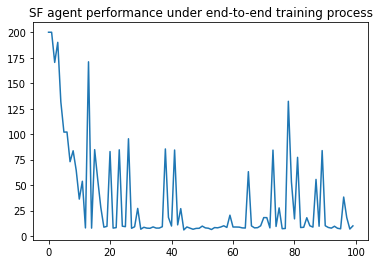

In [ ]:
import matplotlib.pyplot as plt

baseline, eval_baseline = train_agent(MPSF(), FourRoomsMatrix(), exploration_steps=int(1e3))
plt.plot(eval_baseline)
plt.title('SF agent performance under end-to-end training process')

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 170.500
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 151.100
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 170.650
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 141.150
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 170.450
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 122.600
----

Text(0.5, 1.0, 'DQN agent performance under end-to-end training process')

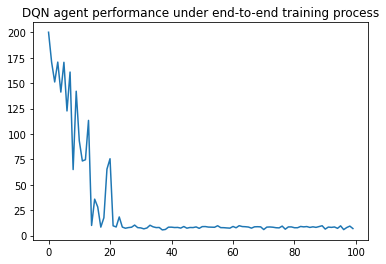

In [ ]:
dqn, eval_dqn = train_agent(DQN(), FourRoomsMatrix(), exploration_steps=int(1e3))
plt.plot(eval_dqn)
plt.title('DQN agent performance under end-to-end training process')

In [ ]:
plt.plot(dqn.)

# Pretrain-SR with random transitions

100%|██████████| 300000/300000 [19:45<00:00, 253.12it/s]


Text(0.5, 1.0, 'pretrain loss when using random transitions')

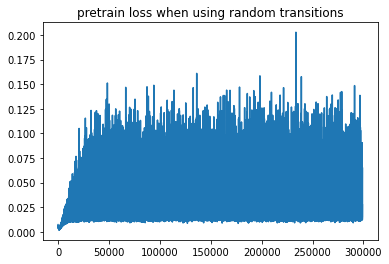

In [ ]:
phase_B_agent = pretrain_agent(MPSF(), FourRoomsMatrixNoTerm(), max_steps=int(3e5))

phase_B_state_dict = phase_B_agent.SF.state_dict()
phase_B_target_state_dict = phase_B_agent.SF_target.state_dict()

plt.plot(phase_B_agent.pre_train_loss)
plt.title('pretrain loss when using random transitions')

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 200.000
----

Text(0.5, 1.0, 'SF agent with pretraining using random transitions --- TD loss')

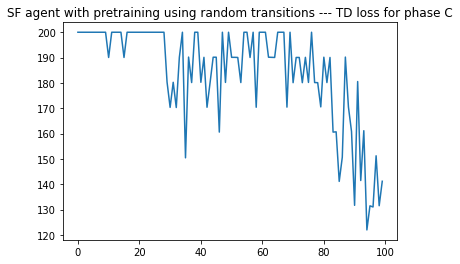

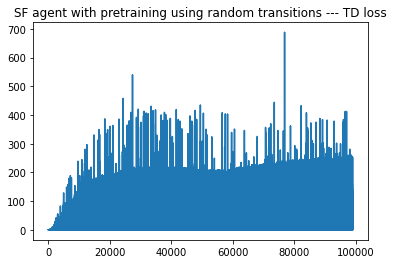

In [ ]:
phase_C_agent_TD = copy.deepcopy(phase_B_agent)
phase_C_agent_TD, eval_TD = train_agent_w(phase_C_agent_TD, FourRoomsMatrix(), TD=True, exploration_steps=int(1e3))

plt.figure()
plt.plot(eval_TD)
plt.title('SF agent with pretraining using random transitions --- TD loss for phase C')

plt.figure()
plt.plot(phase_C_agent_TD.phase_c_TD_loss)
plt.title('SF agent with pretraining using random transitions --- TD loss')

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 180.200
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 170.500
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 190.100
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 131.250
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 180.350
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 160.800
----

Text(0.5, 1.0, 'SF agent with pretraining using random transitions --- Regress loss')

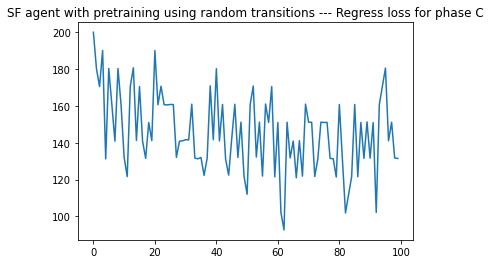

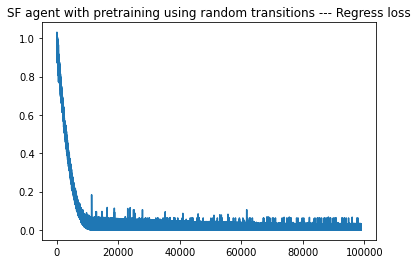

In [ ]:
phase_C_agent_Regress = copy.deepcopy(phase_B_agent)
phase_C_agent_Regress, eval_Regress = train_agent_w(phase_C_agent_Regress, FourRoomsMatrix(), TD=False, exploration_steps=int(1e3))

plt.figure()
plt.plot(eval_Regress)
plt.title('SF agent with pretraining using random transitions --- Regress loss for phase C')

plt.figure()
plt.plot(phase_C_agent_Regress.phase_c_loss)
plt.title('SF agent with pretraining using random transitions --- Regress loss')

# Pretrain-SR with expert transitions

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Workplace/MPSF-final-experiment/

import pickle

with open('./policy_general_MPSF_replay_buffer.pt', 'rb') as f:
    expert_replay_buffer = pickle.load(f)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Workplace/MPSF-final-experiment


100%|██████████| 300000/300000 [19:26<00:00, 257.12it/s]


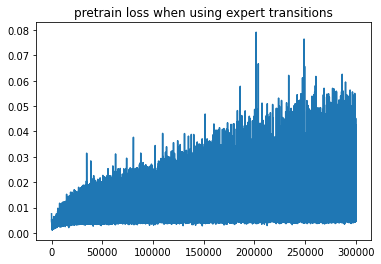

In [ ]:
expert_phase_B_agent = MPSF()
for i in tqdm(range(int(3e5))):
    expert_phase_B_agent.train_SR(expert_replay_buffer, batch_size=16, pretrain_discount=0.99)

plt.plot(expert_phase_B_agent.pre_train_loss)
plt.title('pretrain loss when using expert transitions')

expert_phase_b_state_dict = expert_phase_B_agent.SF.state_dict()

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 190.150
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 180.300
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 190.200
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 190.200
----

Text(0.5, 1.0, 'SF agent with pretraining using expert transitions --- TD loss')

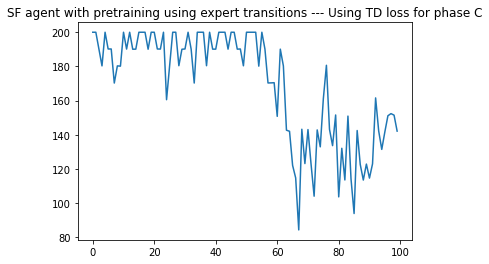

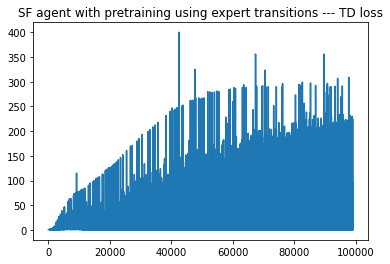

In [ ]:
expert_phase_C_agent_TD = copy.deepcopy(expert_phase_B_agent)
expert_phase_C_agent_TD, expert_eval_TD = train_agent_w(expert_phase_C_agent_TD, FourRoomsMatrix(), TD=True, exploration_steps=int(1e3))

plt.figure()
plt.plot(expert_eval_TD)
plt.title('SF agent with pretraining using expert transitions --- Using TD loss for phase C')

plt.figure()
plt.plot(expert_phase_C_agent_TD.phase_c_TD_loss)
plt.title('SF agent with pretraining using expert transitions --- TD loss')

Evaluation at time step : 1000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 2000
---------------------------------------
Evaluation over 20 episodes: 180.250
---------------------------------------
Evaluation at time step : 3000
---------------------------------------
Evaluation over 20 episodes: 170.400
---------------------------------------
Evaluation at time step : 4000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 5000
---------------------------------------
Evaluation over 20 episodes: 200.000
---------------------------------------
Evaluation at time step : 6000
---------------------------------------
Evaluation over 20 episodes: 180.350
---------------------------------------
Evaluation at time step : 7000
---------------------------------------
Evaluation over 20 episodes: 190.100
----

Text(0.5, 1.0, 'SF agent with pretraining using expert transitions --- Regress loss')

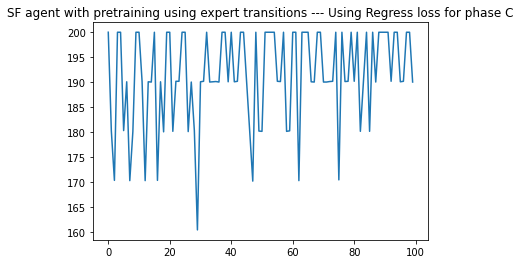

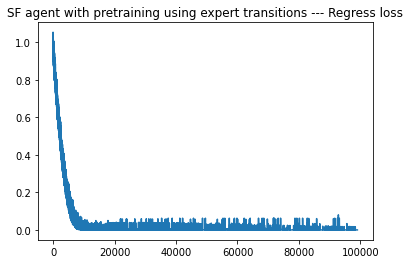

In [ ]:
expert_phase_C_agent_Regress = copy.deepcopy(expert_phase_B_agent)
expert_phase_C_agent_Regress, expert_eval_Regress = train_agent_w(expert_phase_C_agent_Regress, FourRoomsMatrix(), TD=False, exploration_steps=int(1e3))

plt.figure()
plt.plot(expert_eval_Regress)
plt.title('SF agent with pretraining using expert transitions --- Using Regress loss for phase C')

plt.figure()
plt.plot(expert_phase_C_agent_Regress.phase_c_loss)
plt.title('SF agent with pretraining using expert transitions --- Regress loss')

Text(0.5, 1.0, 'SF agent with pretraining using expert transitions --- Regress loss')

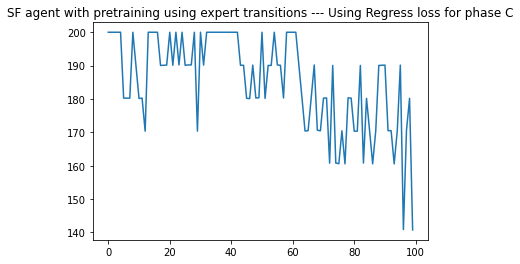

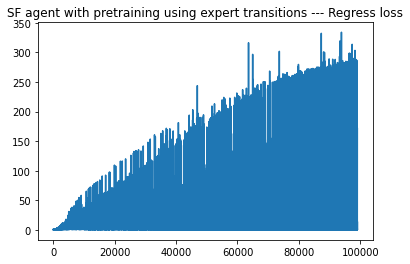

In [ ]:
plt.figure()
plt.plot(expert_eval_Regress)
plt.title('SF agent with pretraining using expert transitions --- Using Regress loss for phase C')

plt.figure()
plt.plot(expert_phase_C_agent_Regress.phase_c_TD_loss)
plt.title('SF agent with pretraining using expert transitions --- Regress loss')

# Collect ReplayBuffer

In [ ]:
expert_replay_buffer = collect_replay_buffer(num_agents=40)

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Workplace/MPSF-final-experiment/

import pickle

with open('./policy_general_MPSF_replay_buffer.pt', 'rb') as f:
    rb = pickle.load(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Workplace/MPSF-final-experiment


In [ ]:
%cd /content/gdrive/MyDrive/Workplace/MPSF-final-experiment/

import pickle 

with open('./policy_general_MPSF_replay_buffer.pt', 'wb') as f:
    pickle.dump(expert_replay_buffer, f)

/content/gdrive/MyDrive/Workplace/MPSF-final-experiment
